In [1]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
from itertools import product as cartesian

import matplotlib as mpl
from matplotlib import animation
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML as HTMLd
from IPython.display import HTML


display(HTML("""
<style>
.output {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
</style>
"""))


$$
\newcommand{\R}{\mathbb{R}}
\newcommand{\vec}[1]{\textbf{#1}}
\newcommand{\vecg}[1]{\boldsymbol{#1}}
\newcommand{\h}{h_{\vecg{\vecg\Theta}}}
\newcommand{\inner}[2]{\langle{#1},{#2}\rangle}
\newcommand{\pd}[1]{\frac{\partial}{\partial{#1}}}
$$
## Linear Regression

Given two matrices $X \in \mathbb{R}^{m\times n}$ and $Y \in \mathbb{R}^{k\times n}$, each representing a set of $n$ observations of $m$ **independent** and $k$ **dependent** variables, along with the assumptions that they form a linear relationship, we can model this as a function:

$$
h(\Theta, \theta_0, X) = \Theta X + \theta_0 \textbf{1}^{1 \times k}
$$

where

$$
\Theta \in \mathbb{R}^{k \times m} \\
\theta_0 \in \mathbb{R}^{k} \\
h_{\Theta} \in \mathbb{R}^{k \times n}
$$

We call this function a **hypothesis**, and the model **linear regression**.

## Cost Function

A good candidate for a cost function in linear regression would be the **Mean Squared Error**, given by:
$$
\begin{align}
J \in \mathbb{R}^{k} = J(\Theta, \theta_0) &= -\frac{1}{2n}\sum^n_i{ (h^i_{\Theta} - y^i)^2 } \\
& = -\frac{1}{2n}\sum^n_i{ (\Theta x^i + \theta_0 - y^i)^2 }
\end{align}
$$

## Minimization

Applying **Gradient Descent** to our model allows us to minimze the cost function and find an optimal solution.
We define gradient descent for $\Theta$ and $\Theta_0$ column-wise (for each independent variable) as:

$$
\theta_j \in \mathbb{R}^k := \theta_j - \alpha\nabla_{\theta_j} J
$$

The gradient of $J$ with respect to $\theta_j$ is

$$
\begin{align}
\nabla_{\theta_j} J &= -\frac{1}{2n}\nabla_{\theta_j}\sum_i^n{\big[ h^i_{\Theta} - y^i \big]^2} \\
&= \Big( -\frac{1}{n}\sum_i^n{\big[ h^i_{\Theta} - y^i \big]} \Big) \cdot
\nabla_{\theta_j}\sum_i^n{\big[ \Theta x^i + \theta_0 \big] } \\
&= -\frac{1}{n}\sum_i^n{\big[ h^i_{\Theta} - y^i \big]} \cdot \nabla_{\theta_j}\sum^n_i{ 
\begin{pmatrix}
\sum^m_l{ ^0\theta_l x^i_l + ^0\theta_{0_l} } \\
\sum^m_l{ ^1\theta_l x^i_l + ^1\theta_{0_l} } \\
... \\
\sum^m_l{ ^k\theta_l x^i_l + ^k\theta_{0_l} }
\end{pmatrix}
}\\
&= -\frac{1}{n}\sum_i^n{\big[ h^i_{\Theta} - y^i \big]} \cdot \sum^n_i{ 
\begin{pmatrix}
x^i_j \\
x^i_j \\
... \\
x^i_j
\end{pmatrix}
}\\
&= -\frac{1}{n}\sum_i^n{\big[ h^i_{\Theta} - y^i \big]} \cdot \sum^n_i{ x^i_j \cdot \textbf{1}^{k\times 1} } \\
&= -\frac{1}{n}\sum_i^n{x^i_j\big[ h^i_{\Theta} - y^i \big]}
\end{align}
$$

where
$$
x^i_j \in \mathbb{R} \\
x^i_0 = 1
$$.

This can be generalized fully into matrix form, giving:

$$
\begin{align}
\Theta :&= \Theta - \alpha \nabla_{\Theta} J \\
&= \Theta - \alpha\frac{1}{n}\sum^n_i{ x^i\big[ h^i_{\Theta} - y^i \big]  }
\end{align}
$$

## Example

Consider the following:

You are given data for students' attendance rate, homework submission rate and past exam scores for English, Mathematics and Physics. Using linear regression, find a relationship between the attendance and submission rate, and exam scores.

### Generating the data

First generate our sample X data and decide on values for $\Theta$ and $\theta_0$.

In [2]:
N = 50

THETA = np.array([
    [90, 10],
    [20, 80],
    [50, 50]
])
THETA_0 = np.array([10, 5, -3])


data = pd.DataFrame([])
norm = lambda a,b,c,d: truncnorm((a - c) / d, (b - c) / d, loc=c, scale=d)
data["x0"] = norm(0, 1, .6, .2).rvs(N)
data["x1"] = norm(0, 1, .5, .15).rvs(N)

for j in range(3):
    data[f"y{j}"] = data[[f"x{i}" for i in range(2)]].to_numpy() @ THETA[j] + THETA_0[j] + np.random.normal(0, 2, N)
    
M = 2
K = 3
Xcol = [x for x in data.columns if x.startswith("x")]
Ycol = [y for y in data.columns if y.startswith("y")]
Xlab = ['attendance', 'submission']
Ylab = ['English', 'Math', 'Physics']

Now let us plot the exam scores one by one.

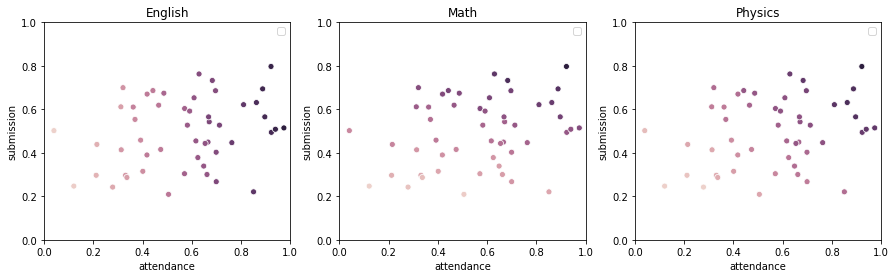

In [3]:
%matplotlib inline
fig1,ax1 = plt.subplots(1, 3)
fig1.set_figwidth(15)

def decorateXY(i, ax):
    ax.set_xlabel(Xlab[0])
    ax.set_ylabel(Xlab[1])
    ax.set_title(Ylab[i])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend([])

for i in range(K):
    sns.scatterplot(data=data, x=Xcol[0], y=Xcol[1], hue=Ycol[i], ax=ax1[i])
    decorateXY(i, ax1[i])

We can see the linear relationship by the color of each plot.

Now we finally implement our model.

First, we define our hypothesis function.

In [4]:
def h(theta, theta_0, x):
    return theta @ x.T + theta_0.reshape(K, 1)

And then the gradient of our cost function $J$ with respect to $\Theta$ and $\theta_0$ respectively.

In [5]:
def dJ_Theta(theta, theta_0):
    k = -1/N
    x = data[Xcol].to_numpy()
    y = data[Ycol].to_numpy().T
    prediction = h(theta, theta_0, x)
    return k * np.inner(x.T, prediction - y).T

def dJ_theta0(theta, theta_0):
    k = -1/N
    x = data[Xcol].to_numpy()
    y = data[Ycol].to_numpy().T
    prediction = h(theta, theta_0, x)
    return k * np.sum(prediction - y, axis=1).T

This is all we need in order to train our model, however it is useful to define $J$ as well, in order to be able to evaluate our model's performance.

In [6]:
def J(theta, theta_0):
    k = -0.5 / N
    x = data[Xcol].to_numpy()
    y = data[Ycol].to_numpy().T
    prediction = h(theta, theta_0, x)
    return np.sum((prediction - y) ** 2, axis=1).T

And now we write the code to actually train our model.

In [7]:
ALPHA = 0.4
COST_THRESHOLD = 200

theta = np.random.rand(K, M) * 100
theta_0 = np.random.rand(K) * 100

def newTheta(theta, theta_0):
    t = dJ_Theta(theta, theta_0)
    t0 = dJ_theta0(theta, theta_0)
    return (theta + ALPHA*t, theta_0 + ALPHA*t0)

# We will store the values of J and Theta/Theta_0 over time in order to plot them
j = [J(theta, theta_0)]
thetas = [theta]
thetas_0 = [theta_0]

while (np.abs(j[-1]) > COST_THRESHOLD).all():
    theta,theta_0 = newTheta(theta, theta_0)
    thetas.append(theta)
    thetas_0.append(theta_0)
    j.append(J(theta, theta_0))
    if (np.abs(j[-1]) > np.abs(j[-2])).any():
        print("We are diverging. Alpha is too high.")
        break

print("Difference between real and approximated theta values:")
print(np.abs(theta - THETA))
print(np.abs(theta_0 - THETA_0))

j = np.array(j)

Difference between real and approximated theta values:
[[ 2.90181395  2.67911298]
 [ 6.19184163 25.674907  ]
 [ 7.27413065 20.69467424]]
[ 0.39188837  9.43593578 14.86304222]


And there it is! We have our optimal $\Theta$ and $\theta_0$ values.

Now let us see how they changed in time.

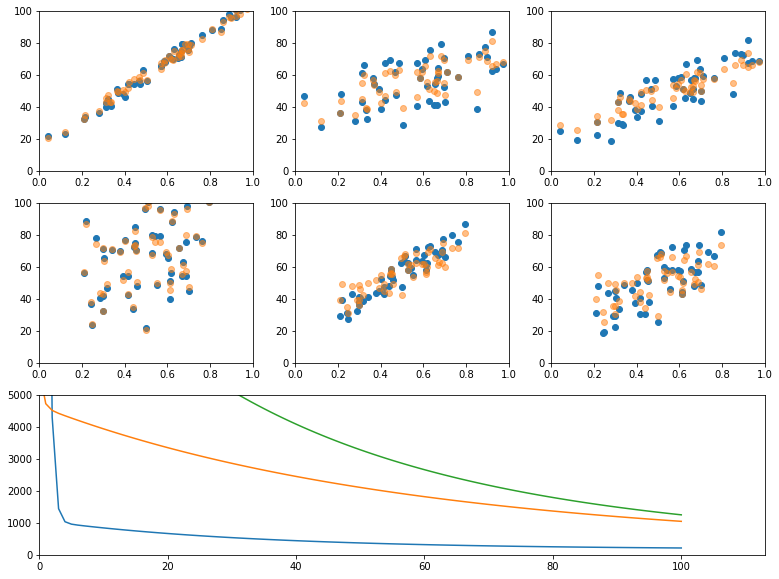

In [8]:
%matplotlib agg
FRAMES = 10

fig2 = plt.figure(figsize=(13, 10))
gs = fig2.add_gridspec(3, 3)
ax_cost = fig2.add_subplot(gs[2, :])
ax_cost.set_xlim(0, len(thetas))
ax_cost.set_ylim(0, 5000)
plot_y = []
cost = []
for k in range(K):
    ps = []
    for m in range(M):
        ax = fig2.add_subplot(gs[m, k])
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 100)
        ax.scatter(data[Xcol[m]], data[Ycol[k]])
        p = ax.scatter([], [], alpha=0.5)
        ps.append(p)
    c = ax_cost.plot([], [])
    cost.append(c[0])
    plot_y.append(ps)
    
def animate(f):
    f = f * len(thetas) // FRAMES
    theta = thetas[f]
    theta_0 = thetas_0[f]
    
    p = h(theta, theta_0, data[Xcol].to_numpy())
    
    for k in range(K):
        for m in range(M):
            pass
            points = np.stack([ data[Xcol[m]], p[k] ]).T
            plot_y[k][m].set_offsets(points)
        cost[k].set_data(range(f), j[:f, k])
    return []

anim = animation.FuncAnimation(fig2, animate, frames=FRAMES, interval=150, blit=True)
HTML(anim.to_html5_video())